# Autorégressions

Un modèle autorégressif $\mathrm{AR}(p)$ est exprimé par :

$$y_t=\delta+\phi_1y_{t-1}+...+\phi_py_{t-p}+\varepsilon_t
$$


L'outil `AutoReg` permet d'implémenter des modèles avec :
+ Termes Déterministes (`trend`) :
  -  `n` : Pas de terme déterministe;
  -  `c` : Avec constante (par défaut);
  -  `ct` : Avec constante et tendance temporelle;
  -  `t` : Avec tendance temporelle uniquement;
  
+ Variables Indicatrices Saisonnières (*i.e.* à valeur $1$ ou $0$) (`seasonal`) :
    - `True` permet d'inclure $s-1$ variables indicatrices, où $s$ est la période de la série.

+ Termes Déterministes personnalisés (`deterministic`) :
    - Prend comme valeur une instance de la classe `DeterministicProcess`.
  
+ Variables Exogènes (`exog`) :
    - Un array ou `dataframe` de variables exogènes à inclure dans le modèle.

La spécification complète est donc :

$$
y_t = \delta_0 + \delta_1 t + \phi_1 y_{t-1} + \ldots + \phi_p y_{t-p} + \sum_{i=1}^{s-1} \gamma_i d_i + \sum_{j=1}^{m} \kappa_j x_{t,j} + \epsilon_t.
$$

où :

+ $d_i$ est une variable saisonnière indicatrice, égale à $1$ si $t\equiv i\mod s$ où $s$ est la période de la série. La période $0$ est exclue si le modèle contient une constante.
+ $t$ est une tendance.
+ $x_{t,j}$ sont des régresseurs exogènes.
+ $\varepsilon_t$ est supposé être un bruit blanc. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(20, 12))
sns.mpl.rc("font", size=14)

La première série étudiée sera le taux de croissance mensuelle des mises en chantier de logements aux États-Unis, qui n'a pas été corrigé des variations saisonnières. La saisonnalité est évidente compte tenu des pics et des creux réguliers observés. 

On met la fréquence de la série temporelle à `MS` (*month-start*) pour éviter les erreurs lors de l'utilisation d'`AutoReg`.

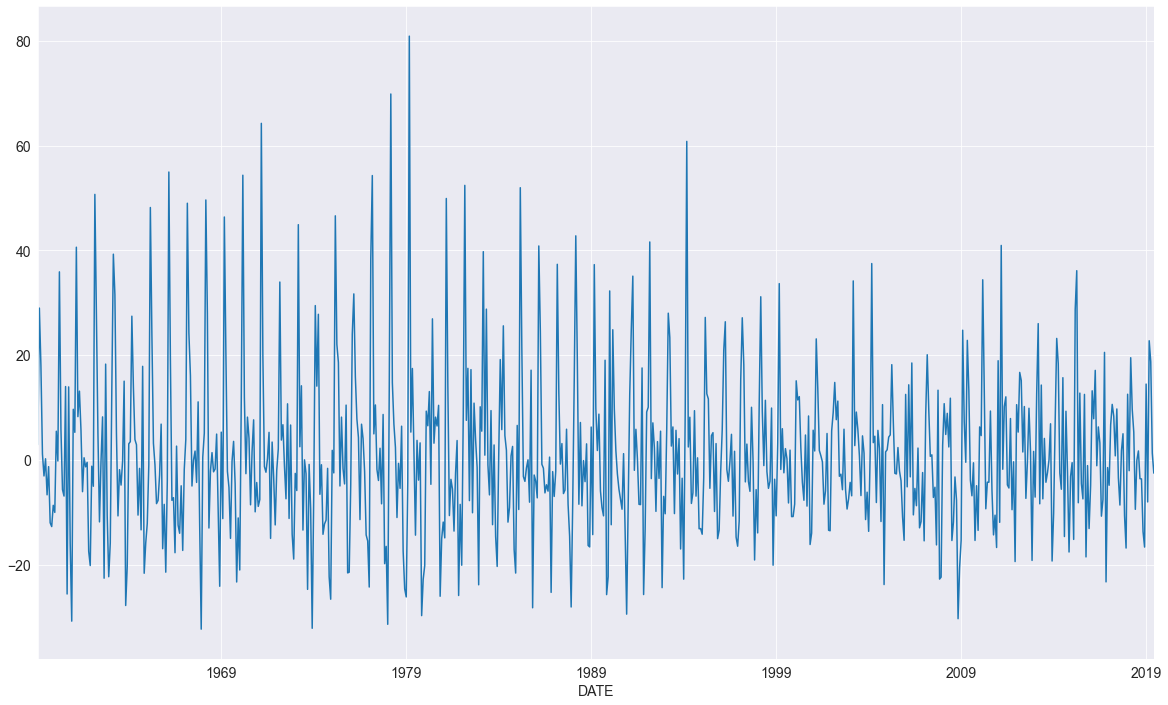

In [3]:
data = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2019-06-01")
housing = data.HOUSTNSA.pct_change().dropna()
# Multiplication par 100 pour obtenir des pourcentages
housing = 100 * housing.asfreq("MS")
fig, ax = plt.subplots()
ax = housing.plot(ax=ax)

On commence dans un premier temps par ajuster un modèle $\mathrm{AR}(3)$.

In [4]:
mod = AutoReg(housing, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                     AutoReg(3)   Log Likelihood               -2993.442
Method:               Conditional MLE   S.D. of innovations             15.289
Date:                Thu, 05 Jan 2023   AIC                           5996.884
Time:                        23:25:07   BIC                           6019.794
Sample:                    05-01-1959   HQIC                          6005.727
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.1228      0.573      1.961      0.050       0.000       2.245
HOUSTNSA.L1     0.1910      0.036      5.235      0.000       0.120       0.263
HOUSTNSA.L2     0.0058      0.037      0.155    

La méthode `ar_select_order` permet de renvoyer les ordres -inférieurs à un ordre passé en paramètre- adéquats pour l'ajustement d'un modèle $\mathrm{AR}$ à un jeu de données.

In [5]:
sel = ar_select_order(housing, 13, old_names=False)
print("Les ordres possibles sont : ", sel.ar_lags)

Les ordres possibles sont :  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Tous les ordres sont possibles. On ajuste alors un modèle $\mathrm{AR}(13)$ :

In [6]:
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:                    AutoReg(13)   Log Likelihood               -2676.157
Method:               Conditional MLE   S.D. of innovations             10.378
Date:                Thu, 05 Jan 2023   AIC                           5382.314
Time:                        23:25:07   BIC                           5450.835
Sample:                    03-01-1960   HQIC                          5408.781
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.3615      0.458      2.970      0.003       0.463       2.260
HOUSTNSA.L1     -0.2900      0.036     -8.161      0.000      -0.360      -0.220
HOUSTNSA.L2     -0.0828      0.031     -2.65

La méthode `plot_predict` permet de visualiser les prévisions. Ici, nous produisons un grand nombre de prévisions qui montrent la saisonnalité capturée par le modèle.

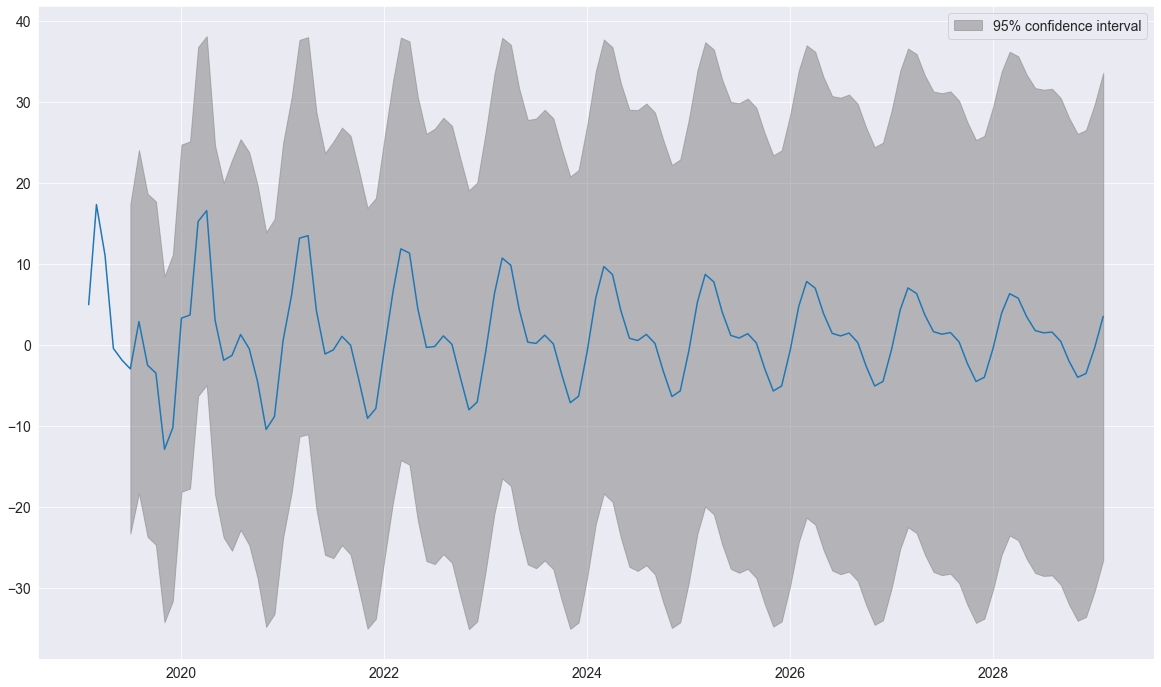

In [7]:
fig = res.plot_predict(720, 840)

`plot_diagnositcs` indique si le modèle capture les caractéristiques essentielles des données.

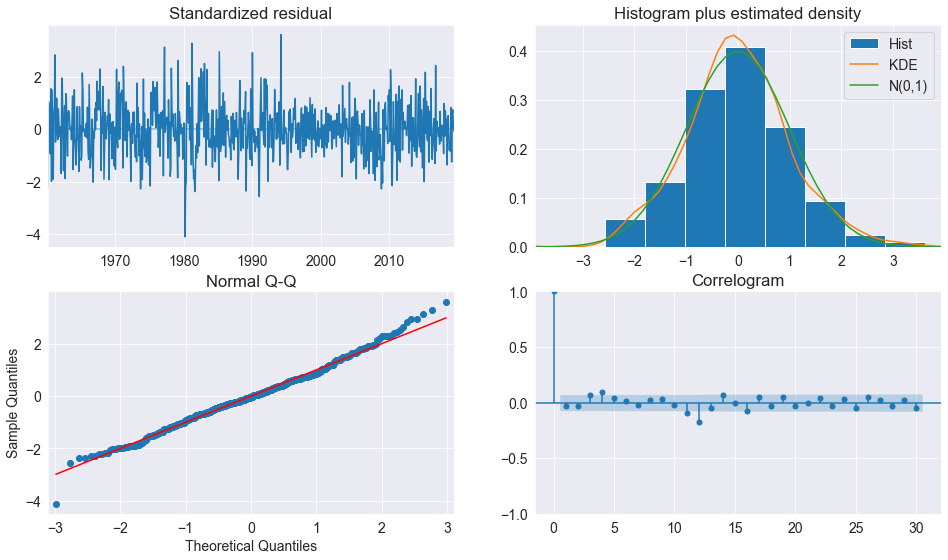

In [8]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

```{admonition} Conclusion
:class: note
Les résidus standardisés suivent selon toute vraisemblance une distribution gaussienne. Le modèle est donc adapté aux données.
```

## Variables Indicatrices (*Dummy*)

`AutoReg` prend en charge les variables indicatrices saisonnières, lesquelles sont une manière alternative de modéliser la saisonnalité. L'inclusion des dummies raccourcit la modélisation à seulement un $\mathrm{AR}(2)$.

In [9]:
sel = ar_select_order(housing, 13, seasonal=True, old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  725
Model:               Seas. AutoReg(2)   Log Likelihood               -2652.556
Method:               Conditional MLE   S.D. of innovations              9.487
Date:                Thu, 05 Jan 2023   AIC                           5335.112
Time:                        23:25:08   BIC                           5403.863
Sample:                    04-01-1959   HQIC                          5361.648
                         - 06-01-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2726      1.373      0.927      0.354      -1.418       3.963
s(2,12)        32.6477      1.824     17.901      0.000      29.073      36.222
s(3,12)        23.0685      2.435      9.472    

Les variables saisonnières sont évidentes dans les prévisions qui ont une composante saisonnière non triviale dans toutes les périodes de 10 ans dans le futur :

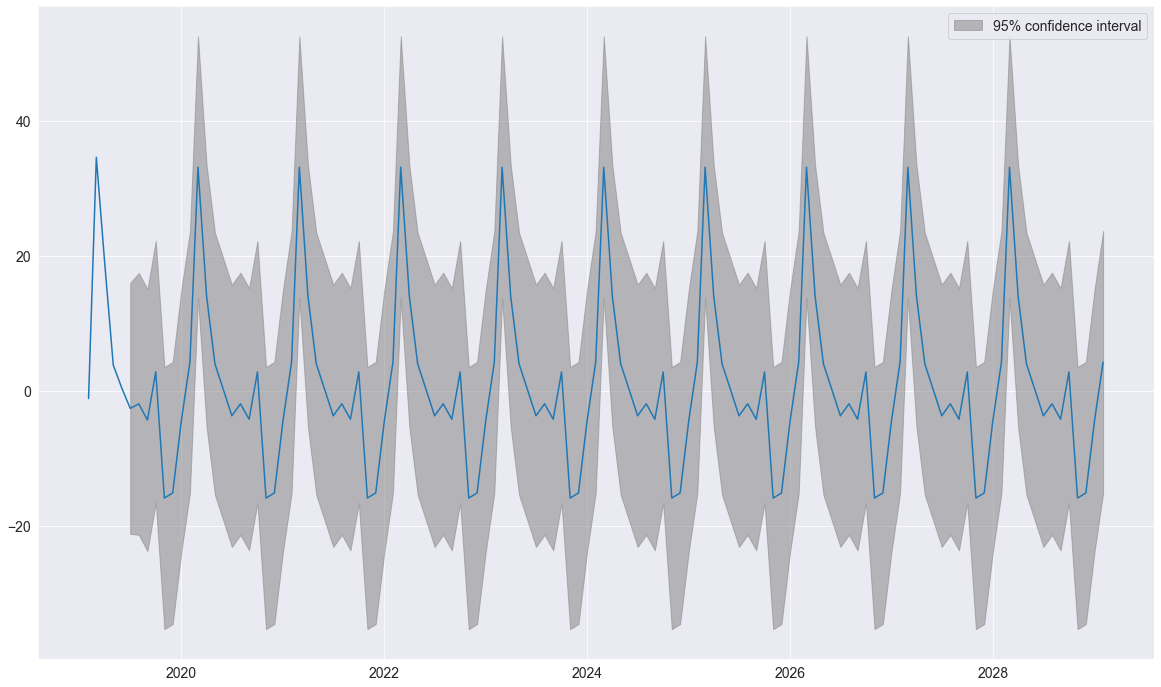

In [10]:
fig = res.plot_predict(720, 840)

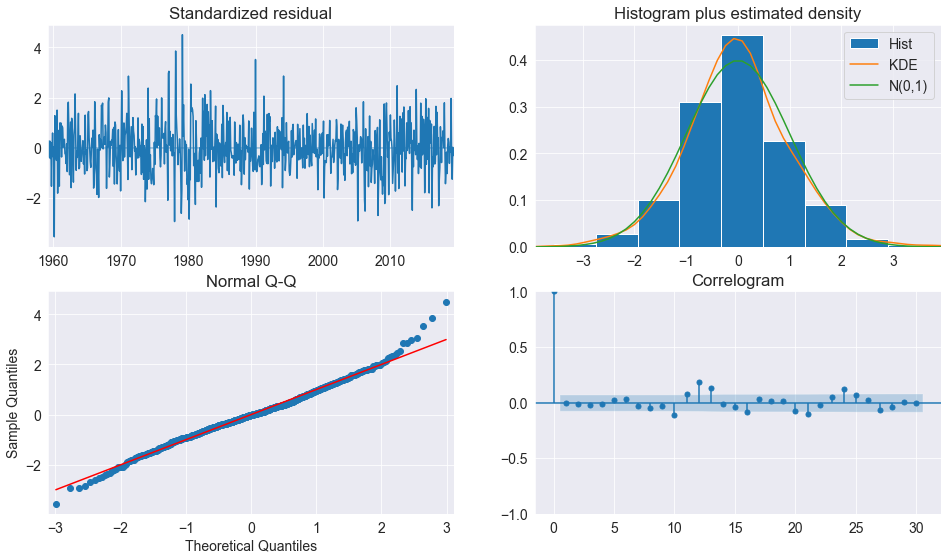

In [11]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(lags=30, fig=fig)

Les résidus standardisés s'apparentent à une réalisation de variables gaussiennes, bien qu'ils comportent des valeurs aberrantes.

## Composantes Saisonnières

Bien qu'`AutoReg` ne supporte pas directement les composantes saisonnières puisqu'il utilise les moindres carrés ordinaires pour estimer les paramètres, il est possible de capturer la saisonnalité en utilisant un $\rm AR$ saisonnier avec des paramètres de trop, ce qui n'impose pas de restrictions.

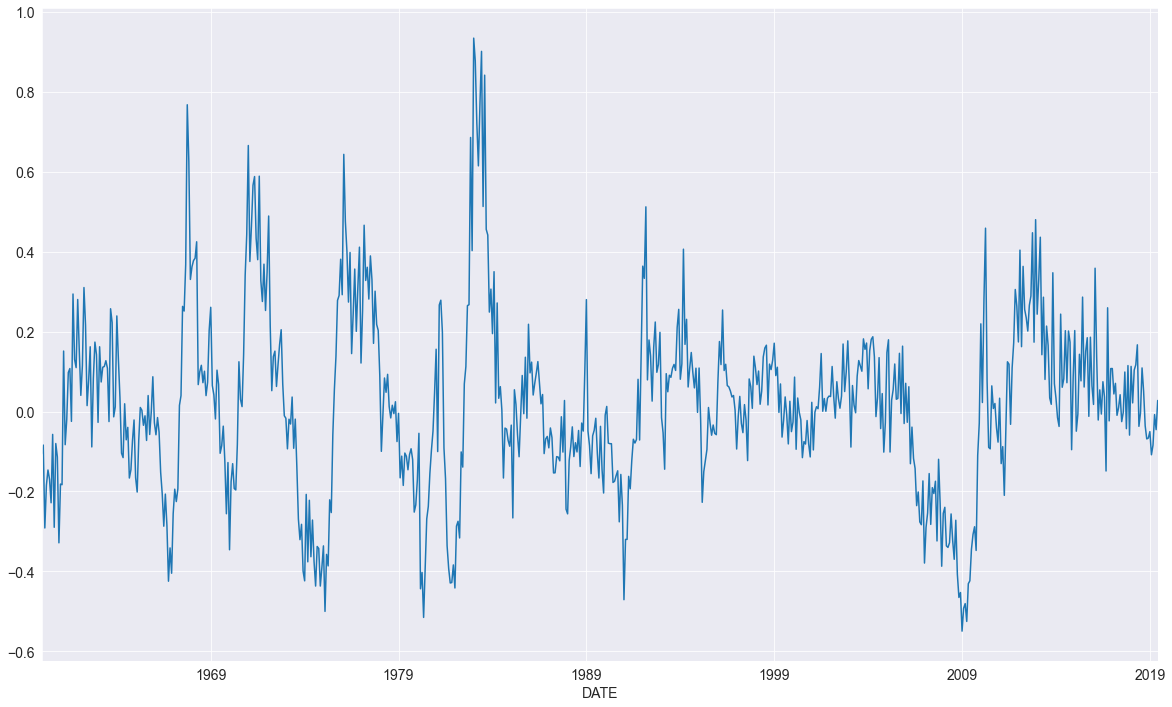

In [12]:
yoy_housing = data.HOUSTNSA.pct_change(12).resample("MS").last().dropna()
_, ax = plt.subplots()
ax = yoy_housing.plot(ax=ax)

On commence par sélectionner un modèle en utilisant la méthode naïve ne choisissant que le retard maximal. Tous les retards inférieurs sont automatiquement inclus. Le retard maximal à vérifier est fixé à $13$, car cela permet au modèle de suivre un $\rm AR$ saisonnier qui comporte à la fois une composante $\mathrm{AR}(1)$ à court terme et une composante $\mathrm{AR}(1)$ saisonnière, de sorte que $(1-\phi_s L^{12})(1-\phi_1 L)y_t = \epsilon_t$. Ainsi :

$$y_t = \phi_1 y_{t-1} +\phi_s Y_{t-12} - \phi_1\phi_s Y_{t-13} + \epsilon_t
$$

In [13]:
sel = ar_select_order(yoy_housing, 13, old_names=False)
sel.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

On constate que tous les ordres sont selectionnés. Nous pouvons mettre `glob=True` pour rechercher tous les modèles qui incluent jusqu'à 13 retards.

In [14]:
sel = ar_select_order(yoy_housing, 13, glob=True, old_names=False)
sel.ar_lags

[1, 2, 3, 7, 12, 13]

Après avoir ajusté le modèle, nous examinons les graphiques de diagnostic qui indiquent que cette paramétrisation semble être adéquate pour capturer la variation des données.

In [15]:
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  714
Model:             Restr. AutoReg(13)   Log Likelihood                 589.177
Method:               Conditional MLE   S.D. of innovations              0.104
Date:                Thu, 05 Jan 2023   AIC                          -1162.353
Time:                        23:25:19   BIC                          -1125.933
Sample:                    02-01-1961   HQIC                         -1148.276
                         - 06-01-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0035      0.004      0.875      0.382      -0.004       0.011
HOUSTNSA.L1      0.5640      0.035     16.167      0.000       0.496       0.632
HOUSTNSA.L2      0.2347      0.038      6.23

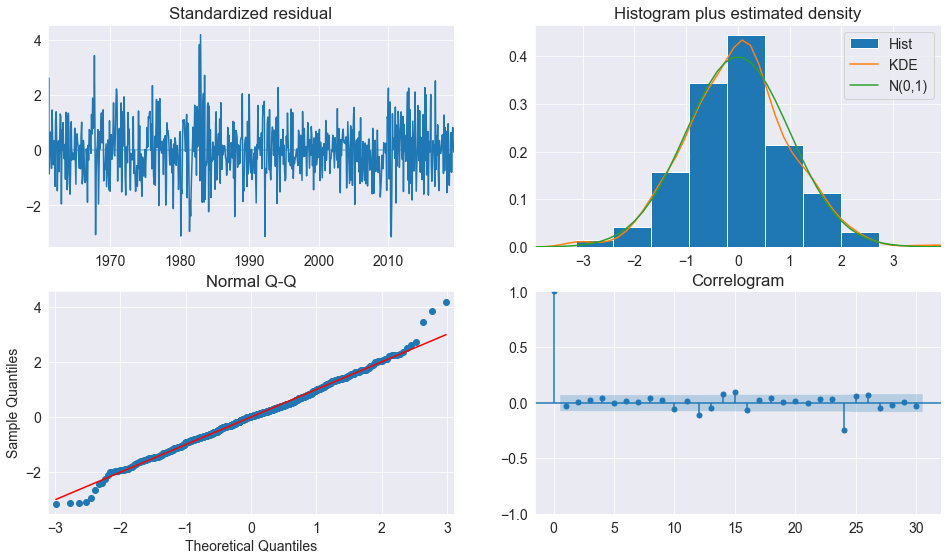

In [16]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

```{admonition} Remarque
:class: note
Il est possible d'inclure des variables saisonnières indicatrices (*dummies*), mais cela importera peu dès lors que le modèle a une fréquence annuelle.
```

## Cas d'école : Production Industrielle

Cette section a trait aux prévisions à la lumière du jeu de données de l'indice de production industrielle de `pandas`.

<AxesSubplot:xlabel='DATE'>

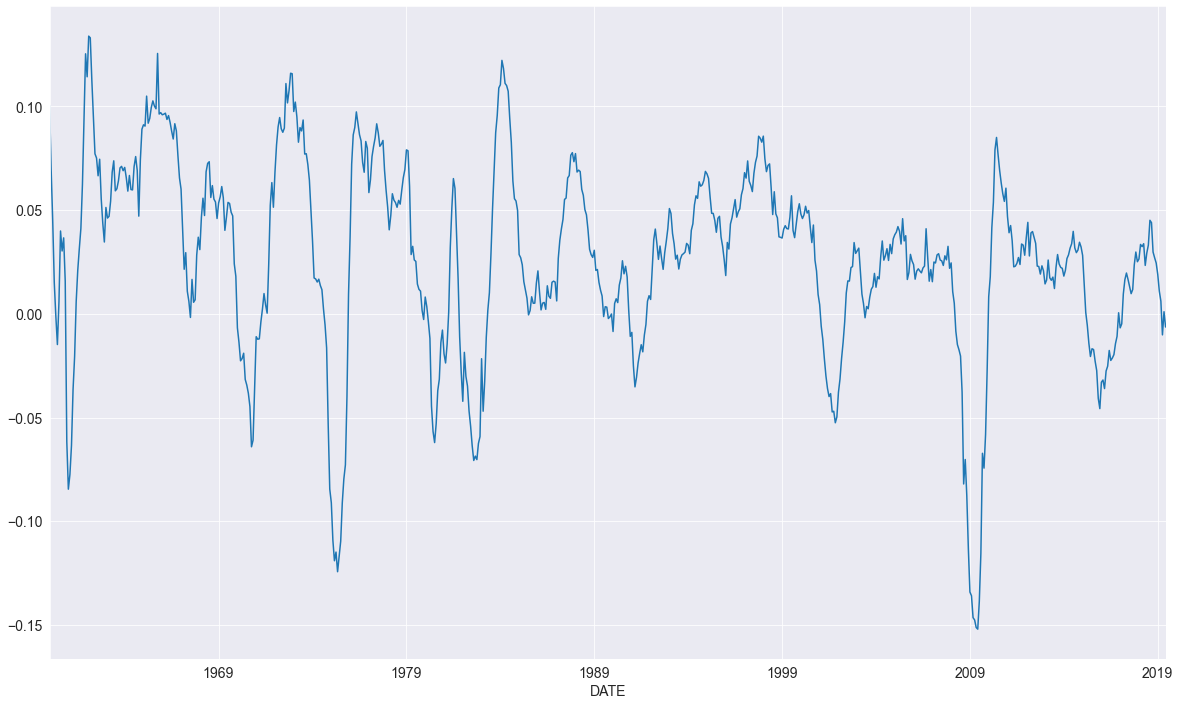

In [17]:
data = pdr.get_data_fred("INDPRO", "1959-01-01", "2019-06-01")
ind_prod = data.INDPRO.pct_change(12).dropna().asfreq("MS")
_, ax = plt.subplots(figsize=(20, 12))
ind_prod.plot(ax=ax)

En premier lieu, on sélectionne un modèle utilisant jusqu'à $12$ retards. Un $\mathrm{AR}(13)$ minimise le critère $\rm BIC$ même si de nombreux coefficients sont non significatifs.

In [18]:
sel = ar_select_order(ind_prod, 13, "bic", old_names=False)
res = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                  714
Model:                    AutoReg(13)   Log Likelihood                2322.270
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Thu, 05 Jan 2023   AIC                          -4614.540
Time:                        23:25:20   BIC                          -4546.252
Sample:                    02-01-1961   HQIC                         -4588.144
                         - 06-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.779      0.005       0.000       0.002
INDPRO.L1      1.1582      0.035     33.196      0.000       1.090       1.227
INDPRO.L2     -0.0824      0.053     -1.546      0.1

On peut également utiliser une recherche globale qui permet d'introduire des retards plus longs si nécessaire, sans exiger les retards plus courts.

In [19]:
sel = ar_select_order(ind_prod, 13, "bic", glob=True, old_names=False)
sel.ar_lags

[1, 5, 12, 13]

De nombreux retards ont été abandonnés. Le modèle indique qu'il peut y avoir une certaine saisonnalité dans les données.

In [20]:
res_glob = sel.model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                 INDPRO   No. Observations:                  714
Model:                    AutoReg(13)   Log Likelihood                2322.270
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Thu, 05 Jan 2023   AIC                          -4614.540
Time:                        23:25:30   BIC                          -4546.252
Sample:                    02-01-1961   HQIC                         -4588.144
                         - 06-01-2019                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      2.779      0.005       0.000       0.002
INDPRO.L1      1.1582      0.035     33.196      0.000       1.090       1.227
INDPRO.L2     -0.0824      0.053     -1.546      0.1

`plot_predict` peut être utilisée pour produire des graphiques de prévision avec des intervalles de confiance. Ici, on trace des prévisions commençant à la dernière observation et se poursuivant pendant $18$ mois.

In [21]:
ind_prod.shape

(714,)

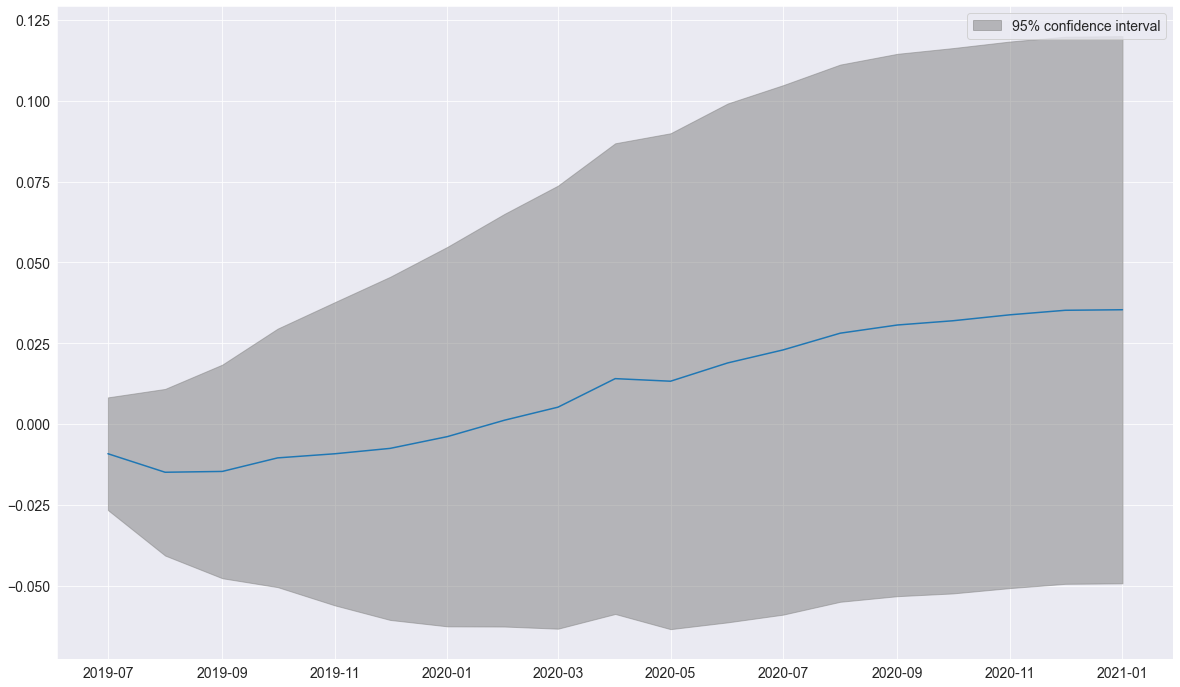

In [22]:
fig = res_glob.plot_predict(start=714, end=732)

Les prévisions du modèle complet et du modèle restreint sont très similaires. À titre indicatif, on inclut également un $\mathrm{AR}(5)$ ayant une variation très différente.

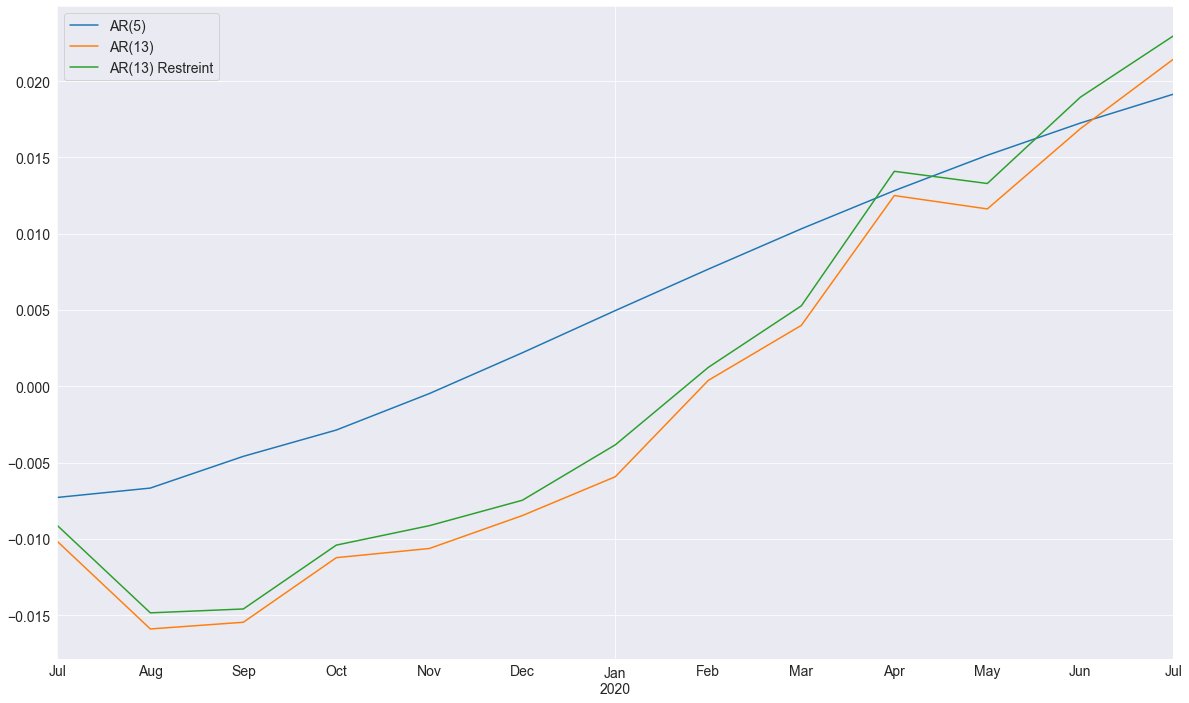

In [23]:
res_ar = AutoReg(ind_prod, 5, old_names=False).fit()
predictions = pd.DataFrame({"AR(5)": res_ar.predict(start=714, end=726),"AR(13)": res.predict(start=714, end=726),"AR(13) Restreint": res_glob.predict(start=714, end=726),})
_, ax = plt.subplots()
ax = predictions.plot(ax=ax)

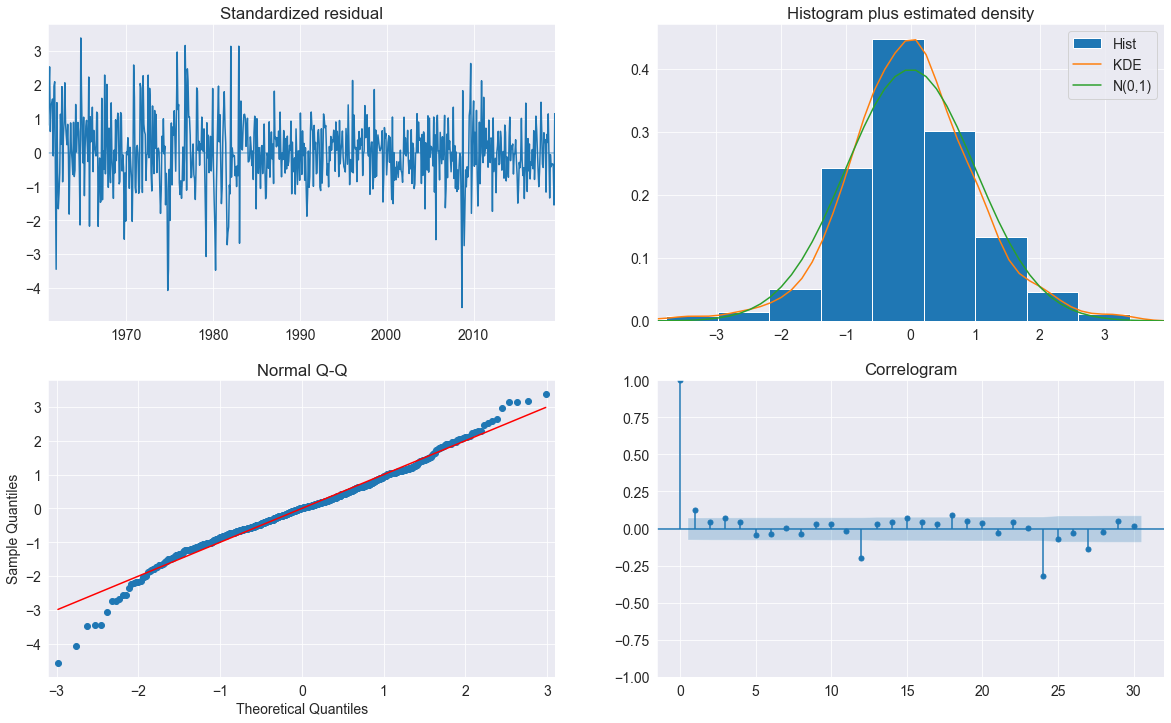

In [24]:
fig = plt.figure(figsize=(20, 12))
fig = res_glob.plot_diagnostics(fig=fig, lags=30)

```{admonition} Conclusion
:class: tip
Les diagnostics indiquent que le modèle capture la plupart de la dynamique des données. Le corrélogramme montre une tendance à la fréquence saisonnière et donc un modèle saisonnier plus complet (type $\rm SARIMAX$) pourrait être nécessaire.
```